     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

SVM Report:
               precision    recall  f1-score   support

    negative       0.82      0.84      0.83       105
    positive       0.82      0.80      0.81        95

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200


CatBoost Report:
               precision    recall  f1-score   support

    negative       0.78      0.72      0.75       105
    positive       0.72      0.78      0.75        95

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75 

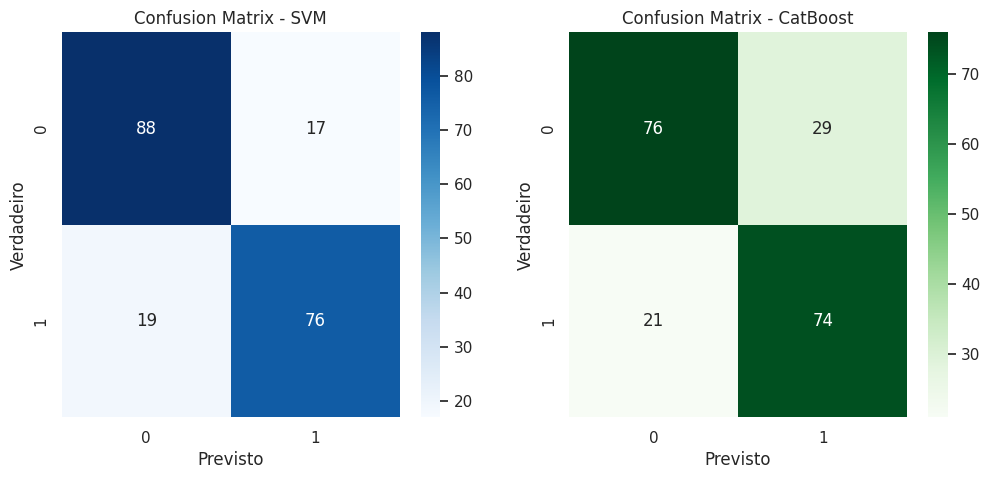

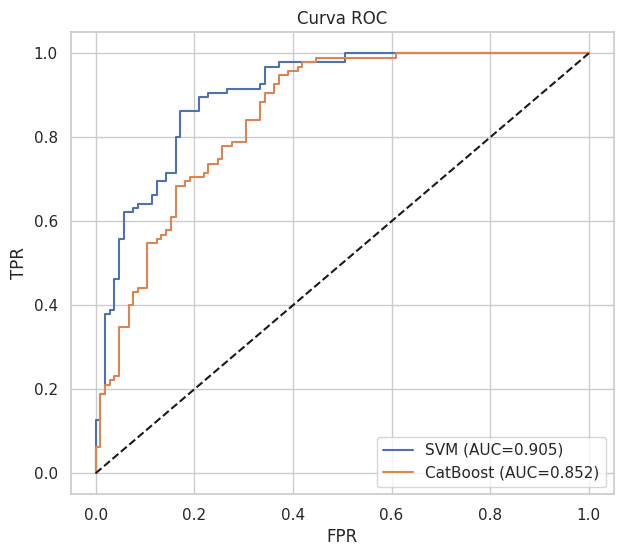

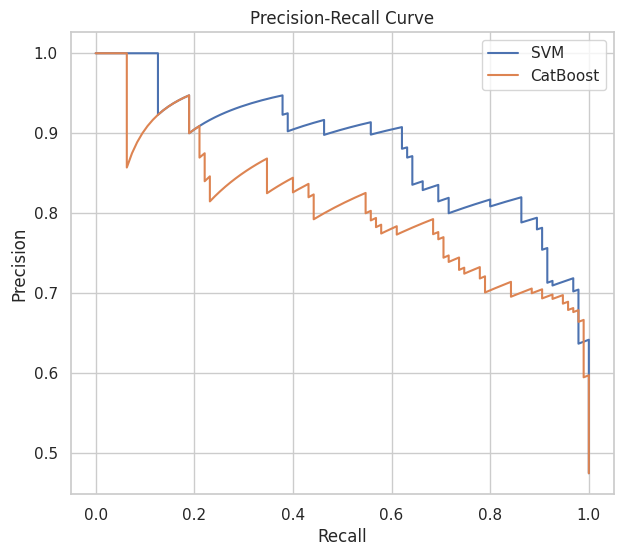

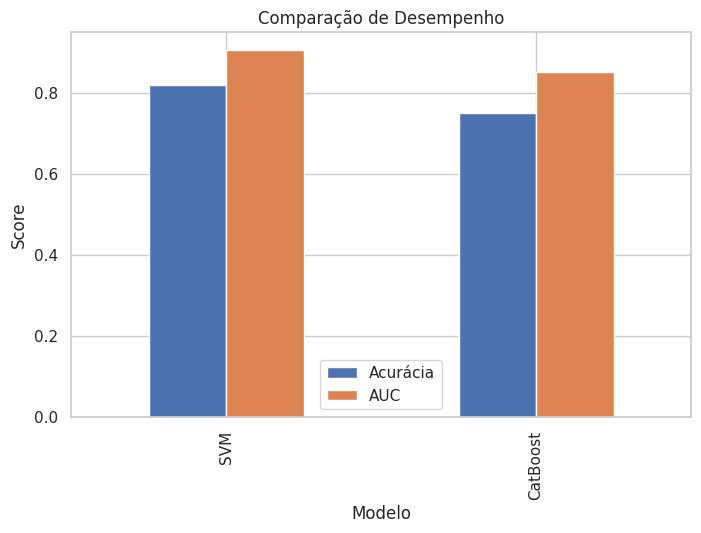

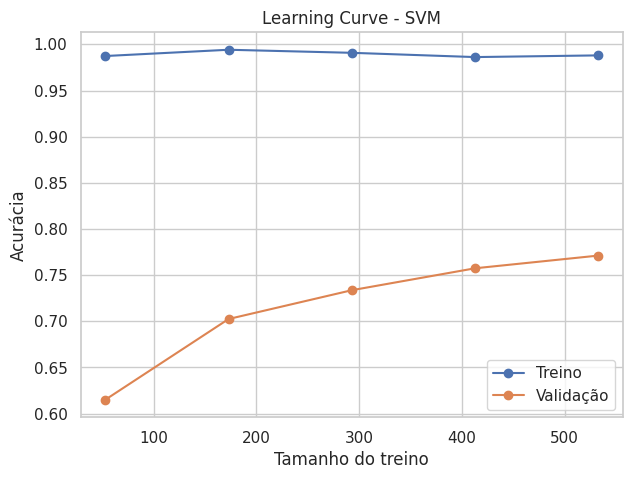

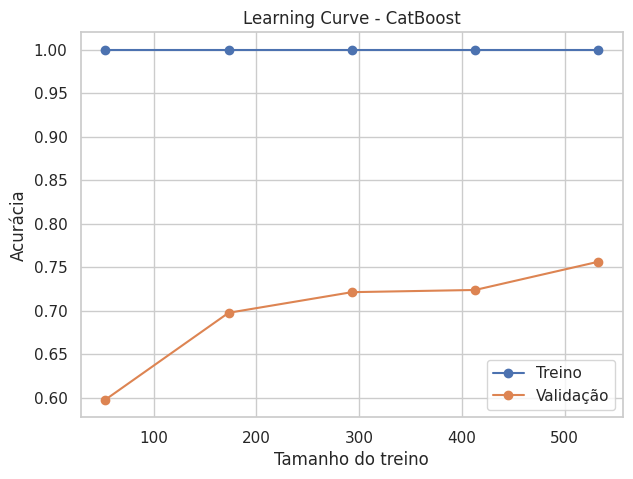

In [ ]:
# Instalação de pacotes
!pip install -q catboost spacy nltk vaderSentiment seaborn
!python -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from nltk.corpus import stopwords
import spacy
from sklearn.preprocessing import LabelEncoder

# Config
SEED = 42
sns.set(style="whitegrid")
np.random.seed(SEED)

# Carregar dataset IMDB
df = pd.read_csv("/content/IMDB Dataset.csv")  # ajuste caminho se necessário
print(df.head())
# Pegar só 10.000 exemplos em vez de 50.000
df = df.sample(1000, random_state=SEED).reset_index(drop=True)

# Pré-processamento
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)       # remove tags HTML
    text = re.sub(r"http\S+|www.\S+", " ", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)   # remove caracteres especiais
    doc = nlp(text)
    return " ".join([t.lemma_ for t in doc if t.lemma_ not in stop_words and not t.is_punct])

df["clean_review"] = df["review"].apply(clean_text)

# Labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])  # positivo=1, negativo=0

X = df["clean_review"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Vetorização
tfidf = TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2))

# ------------------ SVM ------------------
svm_pipeline = Pipeline([
    ("tfidf", tfidf),
    ("svm", SVC(kernel="linear", probability=True, random_state=SEED))
])
svm_pipeline.fit(X_train, y_train)

y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:,1]

print("\nSVM Report:\n", classification_report(y_test, y_pred_svm, target_names=le.classes_))

# ------------------ CatBoost ------------------
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

cat = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, verbose=0, random_state=SEED)
cat.fit(X_train_tfidf, y_train)

y_pred_cat = cat.predict(X_test_tfidf).astype(int)
y_proba_cat = cat.predict_proba(X_test_tfidf)[:,1]

print("\nCatBoost Report:\n", classification_report(y_test, y_pred_cat, target_names=le.classes_))

# ------------------ Métricas comparativas ------------------
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_cat = accuracy_score(y_test, y_pred_cat)

print(f"Acurácia SVM: {acc_svm:.4f} | Acurácia CatBoost: {acc_cat:.4f}")

# ------------------ Gráficos ------------------

# 1. Matrizes de confusão
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix - SVM")
axes[0].set_xlabel("Previsto"); axes[0].set_ylabel("Verdadeiro")

sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", ax=axes[1], cmap="Greens")
axes[1].set_title("Confusion Matrix - CatBoost")
axes[1].set_xlabel("Previsto"); axes[1].set_ylabel("Verdadeiro")
plt.show()

# 2. ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)
auc_svm = auc(fpr_svm, tpr_svm)
auc_cat = auc(fpr_cat, tpr_cat)

plt.figure(figsize=(7,6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={auc_svm:.3f})")
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC={auc_cat:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()

# 3. Precision-Recall
prec_svm, rec_svm, _ = precision_recall_curve(y_test, y_proba_svm)
prec_cat, rec_cat, _ = precision_recall_curve(y_test, y_proba_cat)

plt.figure(figsize=(7,6))
plt.plot(rec_svm, prec_svm, label="SVM")
plt.plot(rec_cat, prec_cat, label="CatBoost")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 4. Gráfico comparativo de acurácia e AUC
metrics_df = pd.DataFrame({
    "Modelo": ["SVM","CatBoost"],
    "Acurácia": [acc_svm, acc_cat],
    "AUC": [auc_svm, auc_cat]
})
metrics_df.plot(x="Modelo", kind="bar", figsize=(8,5))
plt.title("Comparação de Desempenho")
plt.ylabel("Score")
plt.show()

# 5. Curvas de aprendizado
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(7,5))
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, "o-", label="Treino")
    plt.plot(train_sizes, test_scores_mean, "o-", label="Validação")
    plt.title(title)
    plt.xlabel("Tamanho do treino")
    plt.ylabel("Acurácia")
    plt.legend()
    plt.grid(True)
    plt.show()

# Learning Curve para SVM
plot_learning_curve(svm_pipeline, "Learning Curve - SVM", X_train, y_train, cv=3, n_jobs=-1)

# Learning Curve para CatBoost
plot_learning_curve(cat, "Learning Curve - CatBoost", X_train_tfidf, y_train, cv=3, n_jobs=-1)

In [ ]:
# Mostrar apenas os dados usados no TREINO com frases + sentimento
train_df = pd.DataFrame({
    "Frase Treinada": X_train,
    "Sentimento": ["positive" if y == 1 else "negative" for y in y_train]
})

# Exibir as primeiras 30 linhas para não ficar gigante
train_df.head(30)


,Frase Treinada,Sentimento
0,movie good act virtually cast grip story chi...,positive
1,one good film I see age right like trainsp...,positive
2,I enjoy one I relate one time life I try...,positive
3,I black man live predominantly black city sa...,negative
4,old white housewife I still appreciate laurenc...,positive
5,I browse movie demand see underdog free mi...,negative
6,film absolute classic camp elvira mst c...,positive
7,film moment disappointing eye anyway rewor...,negative
8,I much mind factor object act lighting fo...,negative
9,maybe good part show fact creep right conan br...,negative


In [ ]:
# Split com indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, random_state=SEED, stratify=y
)

# Mostrar frases ORIGINAIS usadas no TREINO com sentimento
train_df_original = pd.DataFrame({
    "Frase Original": df.loc[idx_train, "review"].values,
    "Sentimento": ["positive" if y == 1 else "negative" for y in y_train]
})

train_df_original.head(20)


,Frase Original,Sentimento
0,"This movie has very good acting by virtually all the cast, a gripping story with a chilling ending, great music, and excellent visuals without significant special effects. It is interesting to note though that, like so much science fiction, its predictions for the future don't appear likely to come to pass as early as depicted. That's not to say we're out of the woods yet, but 2022 is now obviously too soon to be in this condition. It shares this failing with a fairly illustrious list of science fiction classics: ""1984"", ""2001: A Space Odyssey (compare its space station with our International Space Station) and Isaac Asimov's ""I Robot"" (positronic brains were to have been invented in the 1990's).",positive
1,This is one of the very best films i've seen in ages... it's right up there with the likes of trainspotting and pulp fiction. It just epitomises teenage culture today. The soundtrack is absolutely amazing... overseen by Pete Tong. It's a must see!,positive
2,"I enjoyed this one, because I can relate to it. <br /><br />At one time in my life I was trying to make films, and experienced many of the same problems Mark Borchardt did in trying to make HIS film. And I also went through a protracted period of self-absorbed arrested development, where I refused to grow. But then, miraculously, I got married, and had kids. I realized that being a struggling filmmaker was, in all likelihood, not going to feed my family. So I got a decent job and did what I felt I needed to do to make that happen. That is what an mature, responsible adult does. <br /><br />Mark hasn't faced up to that reality as yet, and so, in that sense, he is a retarded adolescent. For this reason, there is a hopelessness about him. Like Don Quixote, he seems so inept and self-deluded that he doesn't realize how bad off he really is. The viewer feels a sense of superiority and pity for him and his circle. Mark has kids and an ex-wife and bills to pay, but the film depicts him caring basically only about pursuing his ""artistic vision"". <br /><br />Despite this, Mark comes across in the film as a likeable individual, surrounded by a very interesting family and group of friends. Unfortunately, Mark lacks many of the things necessary to be successful both in life and in a career: maturity, responsibility, education, knowledge, life experience, prioritization, financial clout, etc.. Yet he trudges on, much like Ed Wood, apparently without any semblance of a clue. <br /><br />I guess we are supposed to feel encouraged by the spectacle of the ""never say die"" attitude of this noble individual, struggling against the odds. And man, what odds there are! Kiefer Sutherland, Colin Hanks, Tori Spelling and Angelina Jolie are all offspring of big-time film or TV people; no doubt, they will all want to direct some day, if they aren't already. How much room is there for an independent like Mark? It's like watching a guy hit himself in the head with a board, over and over again. Come to think of it, that is pretty close to what happens to one of Mark's actors, with the kitchen cabinet door, in one of the funniest scenes I have ever seen in any movie.<br /><br />Despite these misgivings and seeming criticisms, I truly enjoyed this movie, and would heartily recommend it to anyone. Uncle Bill is amazing. I have a friend who met both Mike and Mark and he told me that, in real life, these guys are just exactly the way they appeared in the movie.",positive
3,"I'm a Black man living in a predominantly Black city. That being said, I have some major misgivings about Tyler Perry's work. I realize that some people out there feel the need to praise him, because he's Black and trying to portray a positive image about the culture. But, I honestly do believe that, were Perry White, this film would have had the NAACP, Al Sharpton, and Jessie Jackson all over his ass.<br /><br />I have been forced to watch this movie one whole hell of a lot recently and each re

In [ ]:
# Mostrar as 20 primeiras linhas com frases completas e emojis
pd.set_option("display.max_colwidth", None)

train_df_original = pd.DataFrame({
    "Frase Original": df.loc[idx_train, "review"].values,
    "Sentimento": ["😊" if y == 1 else "😞" for y in y_train]
})

train_df_original.head(20)


,Frase Original,Sentimento
0,"This movie has very good acting by virtually all the cast, a gripping story with a chilling ending, great music, and excellent visuals without significant special effects. It is interesting to note though that, like so much science fiction, its predictions for the future don't appear likely to come to pass as early as depicted. That's not to say we're out of the woods yet, but 2022 is now obviously too soon to be in this condition. It shares this failing with a fairly illustrious list of science fiction classics: ""1984"", ""2001: A Space Odyssey (compare its space station with our International Space Station) and Isaac Asimov's ""I Robot"" (positronic brains were to have been invented in the 1990's).",😊
1,This is one of the very best films i've seen in ages... it's right up there with the likes of trainspotting and pulp fiction. It just epitomises teenage culture today. The soundtrack is absolutely amazing... overseen by Pete Tong. It's a must see!,😊
2,"I enjoyed this one, because I can relate to it. <br /><br />At one time in my life I was trying to make films, and experienced many of the same problems Mark Borchardt did in trying to make HIS film. And I also went through a protracted period of self-absorbed arrested development, where I refused to grow. But then, miraculously, I got married, and had kids. I realized that being a struggling filmmaker was, in all likelihood, not going to feed my family. So I got a decent job and did what I felt I needed to do to make that happen. That is what an mature, responsible adult does. <br /><br />Mark hasn't faced up to that reality as yet, and so, in that sense, he is a retarded adolescent. For this reason, there is a hopelessness about him. Like Don Quixote, he seems so inept and self-deluded that he doesn't realize how bad off he really is. The viewer feels a sense of superiority and pity for him and his circle. Mark has kids and an ex-wife and bills to pay, but the film depicts him caring basically only about pursuing his ""artistic vision"". <br /><br />Despite this, Mark comes across in the film as a likeable individual, surrounded by a very interesting family and group of friends. Unfortunately, Mark lacks many of the things necessary to be successful both in life and in a career: maturity, responsibility, education, knowledge, life experience, prioritization, financial clout, etc.. Yet he trudges on, much like Ed Wood, apparently without any semblance of a clue. <br /><br />I guess we are supposed to feel encouraged by the spectacle of the ""never say die"" attitude of this noble individual, struggling against the odds. And man, what odds there are! Kiefer Sutherland, Colin Hanks, Tori Spelling and Angelina Jolie are all offspring of big-time film or TV people; no doubt, they will all want to direct some day, if they aren't already. How much room is there for an independent like Mark? It's like watching a guy hit himself in the head with a board, over and over again. Come to think of it, that is pretty close to what happens to one of Mark's actors, with the kitchen cabinet door, in one of the funniest scenes I have ever seen in any movie.<br /><br />Despite these misgivings and seeming criticisms, I truly enjoyed this movie, and would heartily recommend it to anyone. Uncle Bill is amazing. I have a friend who met both Mike and Mark and he told me that, in real life, these guys are just exactly the way they appeared in the movie.",😊
3,"I'm a Black man living in a predominantly Black city. That being said, I have some major misgivings about Tyler Perry's work. I realize that some people out there feel the need to praise him, because he's Black and trying to portray a positive image about the culture. But, I honestly do believe that, were Perry White, this film would have had the NAACP, Al Sharpton, and Jessie Jackson all over his ass.<br /><br />I have been forced to watch this movie one whole hell of a lot recently and each repeated viewing makes 